<a href="https://colab.research.google.com/github/AntonyPyeroRosalesEspinoza/Analisis-de-sentimiento-con-Red-neuronal-Convolucional_2/blob/main/Analisis_de_sentimiento_con_Red_neuronal_Convolucional_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Permisos de google para Drive

In [ ]:
from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import gensim
from gensim.models import KeyedVectors
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers import Embedding

from sklearn.model_selection import KFold

**LEER ARCHIVO EXCEL**

In [ ]:
data=pd.read_excel('/content/drive/MyDrive/Informacion1.xlsx')
data

,Sentimiento,Tweet
0,0,there is no language for such abysms of shriek...
1,1,"I see no difference between the two movements,..."
2,1,I've been making these Balderich comic pages h...
3,0,My Artwork vs AI art
4,0,"Due to copyright concerns, stock image service..."
...,...,...
756,1,"You've been so polite, composed, and informati..."
757,0,If someone codes an AI to play a competitive g...
758,0,A restaurant customer also curates the end res...
759,0,"I did, you just won't accept how it actually i..."


In [ ]:
#Crear Nueva variable para visualizar el excel
my_df=data

In [ ]:
#Visualizar 5 primeras líneas del archivo excel
my_df.head()

,Sentimiento,Tweet
0,0,there is no language for such abysms of shriek...
1,1,"I see no difference between the two movements,..."
2,1,I've been making these Balderich comic pages h...
3,0,My Artwork vs AI art
4,0,"Due to copyright concerns, stock image service..."


In [ ]:
#Elimina valores nulos en las filas
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Sentimiento  761 non-null    int64 
 1   Tweet        761 non-null    object
dtypes: int64(1), object(1)
memory usage: 12.0+ KB


In [ ]:
#Separacion de datos en variables segun la celda Tweet y Sentimiento
x = my_df.Tweet
y = my_df.Sentimiento

**Dividir los datos en entrenamiento y
prueba**

In [ ]:
#Dividiendo los datos para el entrenamiento
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [ ]:
#Datos para entrenamiento / train
"Los datos tiene un total de {0} entradas con {1:.2f}% negativos, {2:.2f}% positivos".format(len(x_train),
                                                                                      (len(x_train[y_train == 0]) / (len(x_train)*1.0))*100,
                                                                                      (len(x_train[y_train == 1]) / (len(x_train)*1.0))*100)

'Los datos tiene un total de 608 entradas con 55.59% negativos, 44.41% positivos'

In [ ]:
#Datos prueba / test
"Los datos tiene un total de {0} entradas con {1:.2f}% negativos, {2:.2f}% positivos".format(len(x_test),
                                                                                      (len(x_test[y_test == 0]) / (len(x_test)*1.0))*100,
                                                                                      (len(x_test[y_test == 1]) / (len(x_test)*1.0))*100)

'Los datos tiene un total de 153 entradas con 60.13% negativos, 39.87% positivos'

**Preparacion de la capa de incrustación**

In [ ]:
#etiquetar los textos para convertirlo en formato para Word2Vec
def labelize_tweets_ug(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
      result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
      return result

In [ ]:
#Combina los datos en un solo conjunto 'all'
all_x = pd.concat([x_train,x_test])
all_x_w2v = labelize_tweets_ug(all_x, 'all')

In [ ]:
#Muestra las etiquetas de los 5 elementos
all_x_w2v[:5]

[TaggedDocument(words=['You', 'can', 'do', 'what', 'many', 'of', 'them', 'cannot.', 'Create', 'entire', 'worlds,', 'Universes', 'using', 'only', 'words.', 'I', 'haven’t', 'finished', 'the', 'Audible', 'of', 'Shadow', 'of', 'the', 'Conqueror', '(yet).', 'What', 'I’ve', 'heard', 'so', 'far', 'I', 'feel', 'like', 'I’m', 'seeing', 'those', 'characters', 'and', 'the', 'entire', 'world', 'you', 'created', 'in', 'my', 'mind.', 'Whether', '“they”', 'like', 'it', 'or', 'not', 'you', 'are', 'an', 'artist', 'my', 'friend.'], tags=['all_214'])]

In [ ]:
#Configura y entrena el modelo Word2Vec para el procesamiento de texto (Se obtiene vocabulario con datos etiquetados)
cores = multiprocessing.cpu_count()
model_ug_sg = Word2Vec(sg=1, vector_size=200, negative=5, window=2,min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|██████████| 1/1 [00:00<00:00, 1431.99it/s]


In [ ]:
#Entrenamiento del modelo word2vec
%%time
for epoch in range(30):
    model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_sg.alpha -= 0.002
    model_ug_sg.min_alpha = model_ug_sg.alpha

100%|██████████| 1/1 [00:00<00:00, 9218.25it/s]


CPU times: user 269 ms, sys: 23.9 ms, total: 293 ms
Wall time: 395 ms


In [ ]:
#Guardar modelo Word2Vec
model_ug_sg.save('w2v_model_ug_sg.word2vec')

In [ ]:
#Cargar modelo Word2Vec
model_ug_sg = KeyedVectors.load('w2v_model_ug_sg.word2vec')

In [ ]:
#Muestra cantidad de vectores del Word2Vec
embedding_index = {}
for w in model_ug_sg.wv.index_to_key:
  embedding_index[w] = model_ug_sg.wv[w]
print('Se encontro %s vectores de palabras.' % len(embedding_index))

Se encontro 7 vectores de palabras.


In [ ]:
#embedding_index['are']

In [ ]:
#Tokenizar para pasar de letras a secuencia de numeros (numero maximo 10000 palabras)
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

In [ ]:
#Total de palabras unicas en el diccionario
len(tokenizer.word_index)

2046

**Mostrar 5 tweets / vectores de palabras de los datos de entrenamiento**

In [ ]:
for x in x_train[:5]:
  print (x)

You can do what many of them cannot. Create entire worlds, Universes using only words. I haven’t finished the Audible of Shadow of the Conqueror (yet). What I’ve heard so far I feel like I’m seeing those characters and the entire world you created in my mind. Whether “they” like it or not you are an artist my friend.
Dawg it's not a tool, it's literally a crutch for you to paint your turds gold and remain delusional just get better at drawing, homie
indeed but also I feel like this was like the original intention, and then capitalism got greedy, as it is wont. It's so dumb that they way you're using it here, which is the RIGHT ETHICAL way, is now basically rebellion
not legally, but actual artists understand that biting a style is a massive no-no in the artistic world. This is not to get confused with taking inspiration from another's style; however, straight up making your work look like someone else's is not something you do in art ia.
The studio's A.I. proposal to SAG-AFTRA included

**Mostrar 5 tweets secuenciales**

In [ ]:
#Muestra los tweets en secuencia / numeral
sequences[:5]

[[9,
  36,
  40,
  33,
  104,
  10,
  88,
  361,
  189,
  416,
  736,
  737,
  45,
  73,
  574,
  7,
  738,
  417,
  1,
  739,
  10,
  740,
  10,
  1,
  741,
  165,
  33,
  312,
  742,
  42,
  275,
  7,
  119,
  23,
  144,
  276,
  153,
  313,
  4,
  1,
  416,
  174,
  9,
  154,
  15,
  31,
  743,
  744,
  745,
  23,
  11,
  51,
  18,
  9,
  17,
  21,
  44,
  31,
  418],
 [1450,
  35,
  18,
  5,
  99,
  35,
  314,
  5,
  1451,
  13,
  9,
  3,
  315,
  26,
  1452,
  1453,
  4,
  1454,
  1455,
  27,
  48,
  113,
  49,
  128,
  1456],
 [244,
  20,
  129,
  7,
  119,
  23,
  16,
  55,
  23,
  1,
  222,
  746,
  4,
  100,
  747,
  316,
  748,
  28,
  11,
  8,
  749,
  35,
  42,
  750,
  14,
  24,
  70,
  130,
  45,
  11,
  145,
  89,
  8,
  1,
  206,
  175,
  70,
  8,
  109,
  575,
  751],
 [18,
  752,
  20,
  362,
  29,
  166,
  14,
  753,
  5,
  131,
  8,
  5,
  754,
  39,
  39,
  15,
  1,
  84,
  174,
  16,
  8,
  18,
  3,
  48,
  755,
  12,
  223,
  576,
  41,
  756,
  131,
  419,
  245

In [ ]:
#Length para contener la longitud de cada texto
length = []
for x in x_train:
  length.append(len(x.split()))

**Midiendo la longitud maxima (ejemplo: si es 51 entonces ligeramente sea superior como 55)**

In [ ]:
#Longitud maxima
max(length)

94

In [ ]:
#Agrega padding a la sequencia de datos entrenamiento (ejemplo: padding 3 para solo uno: 0,0,1 rellena con 0 los vacios)
#maximocam para cambiar el tamaño maximo de la longitud
maximocam= 100
x_train_seq = pad_sequences(sequences, maxlen = maximocam)
print('Tamaño de datos del Tensor:', x_train_seq.shape)

Tamaño de datos del Tensor: (608, 100)


In [ ]:
#Muestra la secuencia con padding
x_train_seq[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    9,   36,   40,
          33,  104,   10,   88,  361,  189,  416,  736,  737,   45,   73,
         574,    7,  738,  417,    1,  739,   10,  740,   10,    1,  741,
         165,   33,  312,  742,   42,  275,    7,  119,   23,  144,  276,
         153,  313,    4,    1,  416,  174,    9,  154,   15,   31,  743,
         744,  745,   23,   11,   51,   18,    9,   17,   21,   44,   31,
         418],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    

In [ ]:
#Agrega padding a la sequencia de datos prueba (ejemplo: padding 3 para solo uno: 0,0,1 rellena con 0 los vacios)
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test,maxlen = maximocam)

In [ ]:
#Matriz de pesos inicial para la capa de embedding
import numpy as np

num_words = 10000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
  if i >= num_words:
    continue
  embedding_vector = embedding_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
    print(word)


the
you
of
like
my
entire


In [ ]:
#Comprobacion de la primera palabra de la matriz con la palabra ('the')
np.array_equal(embedding_matrix[1], embedding_index.get('of'))

False

In [ ]:
seed = 7

In [ ]:
#Concatena la secuencia de numeros / validacion cruzada KFold para dividir en 5 para diferentes iteraciones
x_new = np.concatenate((x_train_seq, x_test_seq), axis=0)
y_new = np.concatenate((y_train, y_test), axis=0)

kf = KFold(n_splits=5, random_state=100, shuffle=True)

In [ ]:
#Creacion del modelo con embeddings
model_ptw2v = Sequential()
e = Embedding(10000, 200, input_length = maximocam)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=5, batch_size=32, verbose= 2)

Epoch 1/5
19/19 - 4s - loss: 0.7233 - accuracy: 0.5822 - val_loss: 0.5984 - val_accuracy: 0.8562 - 4s/epoch - 205ms/step
Epoch 2/5
19/19 - 3s - loss: 0.4481 - accuracy: 0.9046 - val_loss: 0.3893 - val_accuracy: 0.9150 - 3s/epoch - 137ms/step
Epoch 3/5
19/19 - 3s - loss: 0.1717 - accuracy: 0.9967 - val_loss: 0.2083 - val_accuracy: 0.9346 - 3s/epoch - 138ms/step
Epoch 4/5
19/19 - 2s - loss: 0.0456 - accuracy: 0.9967 - val_loss: 0.1423 - val_accuracy: 0.9477 - 2s/epoch - 97ms/step
Epoch 5/5
19/19 - 2s - loss: 0.0142 - accuracy: 0.9984 - val_loss: 0.1267 - val_accuracy: 0.9477 - 2s/epoch - 93ms/step


In [ ]:
#Creacion del modelo con embbedings preentrenado
model_ptw2v = Sequential()
e = Embedding(10000, 200, weights=[embedding_matrix], input_length = maximocam, trainable=True)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=5, batch_size=32, verbose= 2)

Epoch 1/5
19/19 - 3s - loss: 0.6589 - accuracy: 0.6036 - val_loss: 0.5173 - val_accuracy: 0.8039 - 3s/epoch - 142ms/step
Epoch 2/5
19/19 - 2s - loss: 0.2207 - accuracy: 0.9786 - val_loss: 0.1831 - val_accuracy: 0.9216 - 2s/epoch - 96ms/step
Epoch 3/5
19/19 - 2s - loss: 0.0132 - accuracy: 0.9984 - val_loss: 0.1758 - val_accuracy: 0.9346 - 2s/epoch - 89ms/step
Epoch 4/5
19/19 - 2s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.1676 - val_accuracy: 0.9346 - 2s/epoch - 123ms/step
Epoch 5/5
19/19 - 2s - loss: 7.4526e-04 - accuracy: 1.0000 - val_loss: 0.1653 - val_accuracy: 0.9477 - 2s/epoch - 130ms/step


**Red Neuronal Convolucional**

In [ ]:
from keras.src.layers import GlobalMaxPool1D
from keras.layers import Conv1D, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.layers import Input, Dense, concatenate, Activation
from keras.models import Model



#lr = 0.0001 y dropout = 0.2 (hiperparametro lr para actualizar los pesos / dropout previene sobreajuste)
tweet_input = Input(shape=(maximocam,), dtype='int32')

tweet_encoder = Embedding(10000, 200, input_length=maximocam)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu',strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPool1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu',strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPool1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu',strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPool1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation= 'relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
opt = Adam(lr=0.0001)
model = Model(inputs=[tweet_input],outputs=[output])

model.compile(loss='binary_crossentropy',
              optimizer = opt,
              metrics=['accuracy'])
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 embedding_13 (Embedding)    (None, 100, 200)             2000000   ['input_10[0][0]']            
                                                                                                  
 conv1d_27 (Conv1D)          (None, 99, 100)              40100     ['embedding_13[0][0]']        
                                                                                                  
 conv1d_28 (Conv1D)          (None, 98, 100)              60100     ['embedding_13[0][0]']        
                                                                                            

In [ ]:
#Validacion cruzada de Kfold y guarda el peso
from keras.callbacks import ModelCheckpoint

filepath="CNN_best_weightds.{epoch:02d}-{val_accuracy:.4f}.hdf1"
checkpoint =  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

fold_no=1
for train_index, test_index in kf.split(x_train_seq, y_train):
  print('---------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  x_tr, x_te = x_new[train_index], x_new[test_index]
  y_tr, y_te = y_new[train_index], y_new[test_index]

  model.fit(x_tr, y_tr, batch_size=32, epochs=5,
            validation_data=(x_te, y_te), callbacks =[checkpoint])
  fold_no = fold_no + 1


---------------------------------------------------
Training for fold 1 ...
Epoch 1/5
15/16 [===========================>..] - ETA: 0s - loss: 0.6784 - accuracy: 0.5729
Epoch 1: val_accuracy improved from -inf to 0.68852, saving model to CNN_best_weightds.01-0.6885.hdf1
16/16 [==============================] - 5s 207ms/step - loss: 0.6782 - accuracy: 0.5782 - val_loss: 0.6496 - val_accuracy: 0.6885
Epoch 2/5
15/16 [===========================>..] - ETA: 0s - loss: 0.5518 - accuracy: 0.8562
Epoch 2: val_accuracy improved from 0.68852 to 0.78689, saving model to CNN_best_weightds.02-0.7869.hdf1
16/16 [==============================] - 3s 196ms/step - loss: 0.5494 - accuracy: 0.8580 - val_loss: 0.5286 - val_accuracy: 0.7869
Epoch 3/5
15/16 [===========================>..] - ETA: 0s - loss: 0.2904 - accuracy: 0.9521
Epoch 3: val_accuracy improved from 0.78689 to 0.90164, saving model to CNN_best_weightds.03-0.9016.hdf1
16/16 [==============================] - 3s 192ms/step - loss: 0.2893 -

In [ ]:
#lr = 0.001 y dropout = 0.2
tweet_input = Input(shape=(maximocam,), dtype='int32')

tweet_encoder = Embedding(10000, 200, input_length=maximocam)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu',strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPool1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu',strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPool1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu',strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPool1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation= 'relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
opt = Adam(lr=0.001)
model = Model(inputs=[tweet_input],outputs=[output])

model.compile(loss='binary_crossentropy',
              optimizer = opt,
              metrics=['accuracy'])
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 embedding_14 (Embedding)    (None, 100, 200)             2000000   ['input_11[0][0]']            
                                                                                                  
 conv1d_30 (Conv1D)          (None, 99, 100)              40100     ['embedding_14[0][0]']        
                                                                                                  
 conv1d_31 (Conv1D)          (None, 98, 100)              60100     ['embedding_14[0][0]']        
                                                                                           

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath="CNN_best_weightds.{epoch:02d}-{val_accuracy:.4f}.hdf1"
checkpoint =  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

fold_no=1
for train_index, test_index in kf.split(x_train_seq, y_train):
  print('---------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  x_tr, x_te = x_new[train_index], x_new[test_index]
  y_tr, y_te = y_new[train_index], y_new[test_index]

  model.fit(x_tr, y_tr, batch_size=32, epochs=5,
            validation_data=(x_te, y_te), callbacks =[checkpoint])
  fold_no = fold_no + 1


---------------------------------------------------
Training for fold 1 ...
Epoch 1/5
15/16 [===========================>..] - ETA: 0s - loss: 0.6874 - accuracy: 0.5437
Epoch 1: val_accuracy improved from -inf to 0.63934, saving model to CNN_best_weightds.01-0.6393.hdf1
16/16 [==============================] - 4s 200ms/step - loss: 0.6869 - accuracy: 0.5453 - val_loss: 0.6562 - val_accuracy: 0.6393
Epoch 2/5
15/16 [===========================>..] - ETA: 0s - loss: 0.5858 - accuracy: 0.8875
Epoch 2: val_accuracy improved from 0.63934 to 0.73770, saving model to CNN_best_weightds.02-0.7377.hdf1
16/16 [==============================] - 3s 192ms/step - loss: 0.5837 - accuracy: 0.8889 - val_loss: 0.5545 - val_accuracy: 0.7377
Epoch 3/5
16/16 [==============================] - ETA: 0s - loss: 0.3445 - accuracy: 0.9527
Epoch 3: val_accuracy improved from 0.73770 to 0.90984, saving model to CNN_best_weightds.03-0.9098.hdf1
16/16 [==============================] - 4s 277ms/step - loss: 0.3445 -

In [ ]:
#lr = 0.01 y dropout = 0.2
tweet_input = Input(shape=(maximocam,), dtype='int32')

tweet_encoder = Embedding(10000, 200, input_length=maximocam)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu',strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPool1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu',strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPool1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu',strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPool1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation= 'relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
opt = Adam(lr=0.01)
model = Model(inputs=[tweet_input],outputs=[output])

model.compile(loss='binary_crossentropy',
              optimizer = opt,
              metrics=['accuracy'])
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 embedding_15 (Embedding)    (None, 100, 200)             2000000   ['input_12[0][0]']            
                                                                                                  
 conv1d_33 (Conv1D)          (None, 99, 100)              40100     ['embedding_15[0][0]']        
                                                                                                  
 conv1d_34 (Conv1D)          (None, 98, 100)              60100     ['embedding_15[0][0]']        
                                                                                           

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath="CNN_best_weightds.{epoch:02d}-{val_accuracy:.4f}.hdf1"
checkpoint =  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

fold_no=1
for train_index, test_index in kf.split(x_train_seq, y_train):
  print('---------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  x_tr, x_te = x_new[train_index], x_new[test_index]
  y_tr, y_te = y_new[train_index], y_new[test_index]

  model.fit(x_tr, y_tr, batch_size=32, epochs=5,
            validation_data=(x_te, y_te), callbacks =[checkpoint])
  fold_no = fold_no + 1

---------------------------------------------------
Training for fold 1 ...
Epoch 1/5
16/16 [==============================] - ETA: 0s - loss: 0.6870 - accuracy: 0.5617
Epoch 1: val_accuracy improved from -inf to 0.72951, saving model to CNN_best_weightds.01-0.7295.hdf1
16/16 [==============================] - 7s 319ms/step - loss: 0.6870 - accuracy: 0.5617 - val_loss: 0.6724 - val_accuracy: 0.7295
Epoch 2/5
15/16 [===========================>..] - ETA: 0s - loss: 0.6196 - accuracy: 0.7521
Epoch 2: val_accuracy did not improve from 0.72951
16/16 [==============================] - 2s 148ms/step - loss: 0.6192 - accuracy: 0.7510 - val_loss: 0.5941 - val_accuracy: 0.6475
Epoch 3/5
15/16 [===========================>..] - ETA: 0s - loss: 0.4238 - accuracy: 0.9354
Epoch 3: val_accuracy improved from 0.72951 to 0.86066, saving model to CNN_best_weightds.03-0.8607.hdf1
16/16 [==============================] - 3s 186ms/step - loss: 0.4217 - accuracy: 0.9362 - val_loss: 0.4178 - val_accuracy: 0

In [ ]:
#lr = 0.0001 y dropout = 0.3
tweet_input = Input(shape=(maximocam,), dtype='int32')

tweet_encoder = Embedding(10000, 200, input_length=maximocam)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu',strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPool1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu',strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPool1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu',strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPool1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation= 'relu')(merged)
merged = Dropout(0.3)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
opt = Adam(lr=0.0001)
model = Model(inputs=[tweet_input],outputs=[output])

model.compile(loss='binary_crossentropy',
              optimizer = opt,
              metrics=['accuracy'])
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 embedding_16 (Embedding)    (None, 100, 200)             2000000   ['input_13[0][0]']            
                                                                                                  
 conv1d_36 (Conv1D)          (None, 99, 100)              40100     ['embedding_16[0][0]']        
                                                                                                  
 conv1d_37 (Conv1D)          (None, 98, 100)              60100     ['embedding_16[0][0]']        
                                                                                           

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath="CNN_best_weightds.{epoch:02d}-{val_accuracy:.4f}.hdf1"
checkpoint =  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

fold_no=1
for train_index, test_index in kf.split(x_train_seq, y_train):
  print('---------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  x_tr, x_te = x_new[train_index], x_new[test_index]
  y_tr, y_te = y_new[train_index], y_new[test_index]

  model.fit(x_tr, y_tr, batch_size=32, epochs=5,
            validation_data=(x_te, y_te), callbacks =[checkpoint])
  fold_no = fold_no + 1

---------------------------------------------------
Training for fold 1 ...
Epoch 1/5
15/16 [===========================>..] - ETA: 0s - loss: 0.6768 - accuracy: 0.5417
Epoch 1: val_accuracy improved from -inf to 0.62295, saving model to CNN_best_weightds.01-0.6230.hdf1
16/16 [==============================] - 7s 227ms/step - loss: 0.6765 - accuracy: 0.5412 - val_loss: 0.6513 - val_accuracy: 0.6230
Epoch 2/5
15/16 [===========================>..] - ETA: 0s - loss: 0.5659 - accuracy: 0.8188
Epoch 2: val_accuracy improved from 0.62295 to 0.89344, saving model to CNN_best_weightds.02-0.8934.hdf1
16/16 [==============================] - 3s 192ms/step - loss: 0.5652 - accuracy: 0.8210 - val_loss: 0.5490 - val_accuracy: 0.8934
Epoch 3/5
15/16 [===========================>..] - ETA: 0s - loss: 0.3316 - accuracy: 0.9812
Epoch 3: val_accuracy improved from 0.89344 to 0.90984, saving model to CNN_best_weightds.03-0.9098.hdf1
16/16 [==============================] - 3s 196ms/step - loss: 0.3326 -

In [ ]:
#lr = 0.001 y dropout = 0.3
tweet_input = Input(shape=(maximocam,), dtype='int32')

tweet_encoder = Embedding(10000, 200, input_length=maximocam)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu',strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPool1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu',strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPool1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu',strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPool1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation= 'relu')(merged)
merged = Dropout(0.3)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
opt = Adam(lr=0.001)
model = Model(inputs=[tweet_input],outputs=[output])

model.compile(loss='binary_crossentropy',
              optimizer = opt,
              metrics=['accuracy'])
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 embedding_17 (Embedding)    (None, 100, 200)             2000000   ['input_14[0][0]']            
                                                                                                  
 conv1d_39 (Conv1D)          (None, 99, 100)              40100     ['embedding_17[0][0]']        
                                                                                                  
 conv1d_40 (Conv1D)          (None, 98, 100)              60100     ['embedding_17[0][0]']        
                                                                                           

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath="CNN_best_weightds.{epoch:02d}-{val_accuracy:.4f}.hdf1"
checkpoint =  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

fold_no=1
for train_index, test_index in kf.split(x_train_seq, y_train):
  print('---------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  x_tr, x_te = x_new[train_index], x_new[test_index]
  y_tr, y_te = y_new[train_index], y_new[test_index]

  model.fit(x_tr, y_tr, batch_size=32, epochs=5,
            validation_data=(x_te, y_te), callbacks =[checkpoint])
  fold_no = fold_no + 1

---------------------------------------------------
Training for fold 1 ...
Epoch 1/5
15/16 [===========================>..] - ETA: 0s - loss: 0.6805 - accuracy: 0.5729
Epoch 1: val_accuracy improved from -inf to 0.73770, saving model to CNN_best_weightds.01-0.7377.hdf1
16/16 [==============================] - 5s 204ms/step - loss: 0.6804 - accuracy: 0.5761 - val_loss: 0.6630 - val_accuracy: 0.7377
Epoch 2/5
15/16 [===========================>..] - ETA: 0s - loss: 0.5870 - accuracy: 0.8021
Epoch 2: val_accuracy improved from 0.73770 to 0.83607, saving model to CNN_best_weightds.02-0.8361.hdf1
16/16 [==============================] - 3s 189ms/step - loss: 0.5860 - accuracy: 0.8045 - val_loss: 0.5563 - val_accuracy: 0.8361
Epoch 3/5
16/16 [==============================] - ETA: 0s - loss: 0.3654 - accuracy: 0.9506
Epoch 3: val_accuracy improved from 0.83607 to 0.88525, saving model to CNN_best_weightds.03-0.8852.hdf1
16/16 [==============================] - 4s 266ms/step - loss: 0.3654 -

In [ ]:
#lr = 0.01 y dropout = 0.3
tweet_input = Input(shape=(maximocam,), dtype='int32')

tweet_encoder = Embedding(10000, 200, input_length=maximocam)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu',strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPool1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu',strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPool1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu',strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPool1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation= 'relu')(merged)
merged = Dropout(0.3)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
opt = Adam(lr=0.01)
model = Model(inputs=[tweet_input],outputs=[output])

model.compile(loss='binary_crossentropy',
              optimizer = opt,
              metrics=['accuracy'])
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 embedding_18 (Embedding)    (None, 100, 200)             2000000   ['input_15[0][0]']            
                                                                                                  
 conv1d_42 (Conv1D)          (None, 99, 100)              40100     ['embedding_18[0][0]']        
                                                                                                  
 conv1d_43 (Conv1D)          (None, 98, 100)              60100     ['embedding_18[0][0]']        
                                                                                           

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath="CNN_best_weightds.{epoch:02d}-{val_accuracy:.4f}.hdf1"
checkpoint =  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

fold_no=1
for train_index, test_index in kf.split(x_train_seq, y_train):
  print('---------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  x_tr, x_te = x_new[train_index], x_new[test_index]
  y_tr, y_te = y_new[train_index], y_new[test_index]

  model.fit(x_tr, y_tr, batch_size=32, epochs=5,
            validation_data=(x_te, y_te), callbacks =[checkpoint])
  fold_no = fold_no + 1

---------------------------------------------------
Training for fold 1 ...
Epoch 1/5
15/16 [===========================>..] - ETA: 0s - loss: 0.6800 - accuracy: 0.5562
Epoch 1: val_accuracy improved from -inf to 0.56557, saving model to CNN_best_weightds.01-0.5656.hdf1
16/16 [==============================] - 5s 211ms/step - loss: 0.6808 - accuracy: 0.5535 - val_loss: 0.6702 - val_accuracy: 0.5656
Epoch 2/5
15/16 [===========================>..] - ETA: 0s - loss: 0.6026 - accuracy: 0.7437
Epoch 2: val_accuracy improved from 0.56557 to 0.88525, saving model to CNN_best_weightds.02-0.8852.hdf1
16/16 [==============================] - 3s 197ms/step - loss: 0.6018 - accuracy: 0.7449 - val_loss: 0.5811 - val_accuracy: 0.8852
Epoch 3/5
16/16 [==============================] - ETA: 0s - loss: 0.3856 - accuracy: 0.9712
Epoch 3: val_accuracy did not improve from 0.88525
16/16 [==============================] - 3s 183ms/step - loss: 0.3856 - accuracy: 0.9712 - val_loss: 0.3762 - val_accuracy: 0

In [ ]:
#lr = 0.0001 y dropout = 0.4
tweet_input = Input(shape=(maximocam,), dtype='int32')

tweet_encoder = Embedding(10000, 200, input_length=maximocam)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu',strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPool1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu',strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPool1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu',strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPool1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation= 'relu')(merged)
merged = Dropout(0.4)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
opt = Adam(lr=0.0001)
model = Model(inputs=[tweet_input],outputs=[output])

model.compile(loss='binary_crossentropy',
              optimizer = opt,
              metrics=['accuracy'])
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 embedding_19 (Embedding)    (None, 100, 200)             2000000   ['input_16[0][0]']            
                                                                                                  
 conv1d_45 (Conv1D)          (None, 99, 100)              40100     ['embedding_19[0][0]']        
                                                                                                  
 conv1d_46 (Conv1D)          (None, 98, 100)              60100     ['embedding_19[0][0]']        
                                                                                           

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath="CNN_best_weightds.{epoch:02d}-{val_accuracy:.4f}.hdf1"
checkpoint =  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

fold_no=1
for train_index, test_index in kf.split(x_train_seq, y_train):
  print('---------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  x_tr, x_te = x_new[train_index], x_new[test_index]
  y_tr, y_te = y_new[train_index], y_new[test_index]

  model.fit(x_tr, y_tr, batch_size=32, epochs=5,
            validation_data=(x_te, y_te), callbacks =[checkpoint])
  fold_no = fold_no + 1

---------------------------------------------------
Training for fold 1 ...
Epoch 1/5
15/16 [===========================>..] - ETA: 0s - loss: 0.6846 - accuracy: 0.5521
Epoch 1: val_accuracy improved from -inf to 0.63115, saving model to CNN_best_weightds.01-0.6311.hdf1
16/16 [==============================] - 5s 211ms/step - loss: 0.6842 - accuracy: 0.5556 - val_loss: 0.6659 - val_accuracy: 0.6311
Epoch 2/5
15/16 [===========================>..] - ETA: 0s - loss: 0.6187 - accuracy: 0.6917
Epoch 2: val_accuracy improved from 0.63115 to 0.70492, saving model to CNN_best_weightds.02-0.7049.hdf1
16/16 [==============================] - 3s 194ms/step - loss: 0.6178 - accuracy: 0.6934 - val_loss: 0.5967 - val_accuracy: 0.7049
Epoch 3/5
16/16 [==============================] - ETA: 0s - loss: 0.4528 - accuracy: 0.8930
Epoch 3: val_accuracy improved from 0.70492 to 0.90164, saving model to CNN_best_weightds.03-0.9016.hdf1
16/16 [==============================] - 4s 277ms/step - loss: 0.4528 -

In [ ]:
#lr = 0.001 y dropout = 0.4
tweet_input = Input(shape=(maximocam,), dtype='int32')

tweet_encoder = Embedding(10000, 200, input_length=maximocam)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu',strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPool1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu',strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPool1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu',strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPool1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation= 'relu')(merged)
merged = Dropout(0.4)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
opt = Adam(lr=0.001)
model = Model(inputs=[tweet_input],outputs=[output])

model.compile(loss='binary_crossentropy',
              optimizer = opt,
              metrics=['accuracy'])
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 embedding_20 (Embedding)    (None, 100, 200)             2000000   ['input_17[0][0]']            
                                                                                                  
 conv1d_48 (Conv1D)          (None, 99, 100)              40100     ['embedding_20[0][0]']        
                                                                                                  
 conv1d_49 (Conv1D)          (None, 98, 100)              60100     ['embedding_20[0][0]']        
                                                                                           

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath="CNN_best_weightds.{epoch:02d}-{val_accuracy:.4f}.hdf1"
checkpoint =  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

fold_no=1
for train_index, test_index in kf.split(x_train_seq, y_train):
  print('---------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  x_tr, x_te = x_new[train_index], x_new[test_index]
  y_tr, y_te = y_new[train_index], y_new[test_index]

  model.fit(x_tr, y_tr, batch_size=32, epochs=5,
            validation_data=(x_te, y_te), callbacks =[checkpoint])
  fold_no = fold_no + 1

---------------------------------------------------
Training for fold 1 ...
Epoch 1/5
15/16 [===========================>..] - ETA: 0s - loss: 0.6925 - accuracy: 0.5708
Epoch 1: val_accuracy improved from -inf to 0.85246, saving model to CNN_best_weightds.01-0.8525.hdf1
16/16 [==============================] - 5s 246ms/step - loss: 0.6929 - accuracy: 0.5658 - val_loss: 0.6687 - val_accuracy: 0.8525
Epoch 2/5
16/16 [==============================] - ETA: 0s - loss: 0.6255 - accuracy: 0.7346
Epoch 2: val_accuracy did not improve from 0.85246
16/16 [==============================] - 2s 113ms/step - loss: 0.6255 - accuracy: 0.7346 - val_loss: 0.6065 - val_accuracy: 0.7131
Epoch 3/5
15/16 [===========================>..] - ETA: 0s - loss: 0.4671 - accuracy: 0.9708
Epoch 3: val_accuracy improved from 0.85246 to 0.88525, saving model to CNN_best_weightds.03-0.8852.hdf1
16/16 [==============================] - 3s 224ms/step - loss: 0.4660 - accuracy: 0.9691 - val_loss: 0.4593 - val_accuracy: 0

In [ ]:
#lr = 0.01 y dropout = 0.4
tweet_input = Input(shape=(maximocam,), dtype='int32')

tweet_encoder = Embedding(10000, 200, input_length=maximocam)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu',strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPool1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu',strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPool1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu',strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPool1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation= 'relu')(merged)
merged = Dropout(0.4)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
opt = Adam(lr=0.01)
model = Model(inputs=[tweet_input],outputs=[output])

model.compile(loss='binary_crossentropy',
              optimizer = opt,
              metrics=['accuracy'])
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 embedding_21 (Embedding)    (None, 100, 200)             2000000   ['input_18[0][0]']            
                                                                                                  
 conv1d_51 (Conv1D)          (None, 99, 100)              40100     ['embedding_21[0][0]']        
                                                                                                  
 conv1d_52 (Conv1D)          (None, 98, 100)              60100     ['embedding_21[0][0]']        
                                                                                           

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath="CNN_best_weightds.{epoch:02d}-{val_accuracy:.4f}.hdf1"
checkpoint =  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

fold_no=1
for train_index, test_index in kf.split(x_train_seq, y_train):
  print('---------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  x_tr, x_te = x_new[train_index], x_new[test_index]
  y_tr, y_te = y_new[train_index], y_new[test_index]

  model.fit(x_tr, y_tr, batch_size=32, epochs=5,
            validation_data=(x_te, y_te), callbacks =[checkpoint])
  fold_no = fold_no + 1

---------------------------------------------------
Training for fold 1 ...
Epoch 1/5
15/16 [===========================>..] - ETA: 0s - loss: 0.6852 - accuracy: 0.5542
Epoch 1: val_accuracy improved from -inf to 0.76230, saving model to CNN_best_weightds.01-0.7623.hdf1
16/16 [==============================] - 5s 210ms/step - loss: 0.6853 - accuracy: 0.5576 - val_loss: 0.6642 - val_accuracy: 0.7623
Epoch 2/5
15/16 [===========================>..] - ETA: 0s - loss: 0.6133 - accuracy: 0.6729
Epoch 2: val_accuracy did not improve from 0.76230
16/16 [==============================] - 2s 115ms/step - loss: 0.6119 - accuracy: 0.6770 - val_loss: 0.5916 - val_accuracy: 0.7623
Epoch 3/5
15/16 [===========================>..] - ETA: 0s - loss: 0.4294 - accuracy: 0.9333
Epoch 3: val_accuracy improved from 0.76230 to 0.85246, saving model to CNN_best_weightds.03-0.8525.hdf1
16/16 [==============================] - 3s 211ms/step - loss: 0.4275 - accuracy: 0.9342 - val_loss: 0.4369 - val_accuracy: 0

In [ ]:
#Cargar modelo segun el nombre del archivo anterior con el modelo de mejor peso
from keras.models import load_model
loaded_CNN_model = load_model('CNN_best_weightds.01-1.0000.hdf1')
loaded_CNN_model.evaluate(x=x_te, y=y_te)

#[perdida aproximada, precision aproximada]

4/4 [==============================] - 0s 27ms/step - loss: 0.0053 - accuracy: 1.0000


[0.0053399489261209965, 1.0]

**Evaluación final del modelo con datos**

In [ ]:
#Tokenizacion de las palabras en tokens y establece longitud de la secuencia segun la longitud
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen=maximocam)

In [ ]:
#Carga de modelo CNN
loaded_CNN_model.evaluate(x=x_test_seq, y=y_test)
#[perdida aproximada, precision aproximada]

5/5 [==============================] - 1s 52ms/step - loss: 0.1812 - accuracy: 0.8889


[0.18120814859867096, 0.8888888955116272]

In [ ]:
#Convierte la prediccion del modelo en 1 o 0
y_temp = loaded_CNN_model.predict(x_test_seq)
yhat_cnn = []
for i in range(0, len(y_temp)):
  if(y_temp[i] > 1-y_temp[i]):
    yhat_cnn.append(1)
  else:
    yhat_cnn.append(0)
  print(yhat_cnn)

5/5 [==============================] - 0s 42ms/step
[1]
[1, 0]
[1, 0, 1]
[1, 0, 1, 0]
[1, 0, 1, 0, 1]
[1, 0, 1, 0, 1, 0]
[1, 0, 1, 0, 1, 0, 0]
[1, 0, 1, 0, 1, 0, 0, 1]
[1, 0, 1, 0, 1, 0, 0, 1, 0]
[1, 0, 1, 0, 1, 0, 0, 1, 0, 0]
[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0]
[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]
[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0]
[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1]
[1, 0, 1, 0, 1, 0, 0, 1,

In [ ]:
from sklearn.metrics import confusion_matrix

#Matriz de contingencia para evaluar el rendimiento
#[[VP=verdadero positivo, FP=Falso positivo],
#[FN=Falso negativo, VP=Verdadero negativo]]

confusion_matrix(y_test, yhat_cnn)

array([[85,  7],
       [10, 51]])

<function matplotlib.pyplot.show(close=None, block=None)>

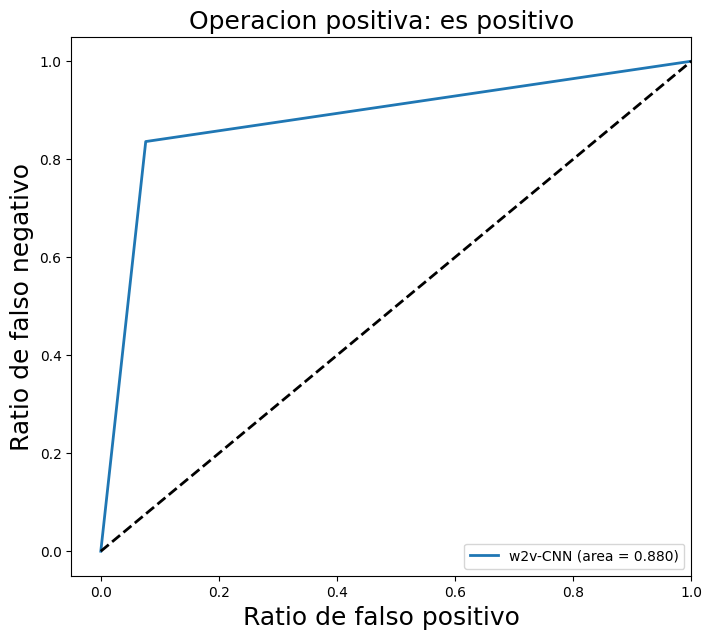

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#Graficando la ruta ROC
# Si el AUC = 0.7 entonces es un 70% de que pueda distinguir la clasificacion
# Si el AUC = 0.5 entonces no puede distinguir eficientemente
fpr_cnn, tpr_cnn, threshold = roc_curve(y_test, yhat_cnn)
roc_auc_nn = auc(fpr_cnn, tpr_cnn)
plt.figure(figsize=(8,7))
plt.plot(fpr_cnn, tpr_cnn, label='w2v-CNN (area = %0.3f)' % roc_auc_nn, linewidth=2)

plt.plot([0,1],[0,1], 'k--', linewidth = 2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('Ratio de falso positivo', fontsize= 18)
plt.ylabel('Ratio de falso negativo', fontsize= 18)
plt.title('Operacion positiva: es positivo', fontsize=18)
plt.legend(loc = "lower right")
plt.show

In [ ]:
#Muestra los valores de la curva ROC
#fpr_cnn es falso positivo en diferentes cortes del cuadro
#tpr_cnn es verdadero positivo en diferentes cortes del cuadro
#roc_auc_nn area de la Curva ROC
fpr_cnn, tpr_cnn, roc_auc_nn

(array([0.        , 0.07608696, 1.        ]),
 array([0.        , 0.83606557, 1.        ]),
 0.8799893086243763)

In [ ]:
#y_test se  muestra la columna de los valores con 1 o 0 (positivo/negativo)
#y_temp se muestra la instancia de una probabilidad que pertenezca a la clase positiva
#yhat_cnn prediccion con umbral que muestra 1 o 0 (positivo/negativo)
#y_temp.shape muestra la matriz en (filas/columnas)
import pandas as pd

print("Tabla de prediccion de los datos con la red neuronal")
df = pd.DataFrame({'Frases': x_test,'Pred.': y_test,'Pred.Red': yhat_cnn})

df.index = df.index + 1  # Sumar 1 a los índices para iniciar desde 1 en lugar de 0


# Mostrar el DataFrame
print(df)

Tabla de prediccion de los datos con la red neuronal
                                                Frases  Pred.  Pred.Red
201  I personally don’t respect a lot of people’s o...      1         1
37   I have obviously chosen not to include any of ...      0         0
758  If someone codes an AI to play a competitive g...      0         1
470  Instead of Green Skull, all we're left with is...      0         0
575  I agree. I have been honing my skills with ai....      1         1
..                                                 ...    ...       ...
33   I have written another post about AI generated...      0         0
47   QRT and release something in the IA gallery th...      1         1
15   Just to add, this is the first of many to come...      1         0
516  Graphic Designers are going to do just fine if...      1         0
123                                Night drive with ia      1         1

[153 rows x 3 columns]


In [ ]:
print("Probabilidad que sea positivo o negativo segun la CNN")
print(y_temp)
print("Tamaño de la matriz")
print(y_temp.shape)

Probabilidad que sea positivo o negativo segun la CNN
[[9.8189157e-01]
 [3.6690473e-03]
 [5.9202766e-01]
 [1.0554906e-02]
 [9.9649590e-01]
 [9.4487285e-03]
 [4.7833426e-04]
 [9.9540633e-01]
 [6.8553969e-02]
 [1.0851822e-03]
 [5.3435545e-02]
 [2.2065213e-03]
 [6.7147329e-02]
 [5.6756530e-03]
 [3.6690473e-03]
 [2.8868115e-03]
 [1.9413678e-03]
 [3.1238249e-01]
 [9.9118179e-01]
 [9.0548390e-01]
 [9.6895647e-01]
 [9.7156197e-01]
 [2.2798970e-02]
 [9.9027628e-01]
 [1.9686786e-03]
 [1.8343462e-02]
 [1.6752995e-03]
 [4.8648185e-01]
 [9.8520029e-01]
 [3.1509984e-02]
 [5.3435545e-02]
 [9.8268974e-01]
 [2.6534356e-03]
 [3.1637123e-03]
 [3.8589453e-03]
 [9.9320590e-01]
 [9.9046457e-01]
 [9.9263579e-01]
 [2.9008922e-03]
 [9.8189157e-01]
 [1.5485922e-03]
 [9.5622379e-01]
 [5.6756530e-03]
 [2.2214385e-02]
 [2.9081453e-03]
 [8.2990009e-01]
 [1.7551599e-03]
 [9.9244171e-01]
 [9.9485648e-01]
 [1.9184992e-02]
 [9.7576761e-01]
 [7.9390202e-03]
 [4.0907110e-03]
 [9.8991364e-01]
 [9.9644774e-01]
 [2.1870019